In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from astropy.stats import sigma_clip
from scipy.stats import entropy

rng = np.random.default_rng()

In [41]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c', 'log_x0', 'log_x1', 'log_ia_chisq']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej', 'log_fni', 'log_mej', 'log_ibc_chisq']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [42]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [43]:
data = np.load("fitted_sne_real_012826.npz", allow_pickle=True)
phot_data = np.load("fitted_sne_real_012126_phot.npz", allow_pickle=True)

true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
true_ia_phot_sne = phot_data['ia']
true_ibc_phot_sne = phot_data['ibc']
all_phot_sne = np.concatenate((true_ia_phot_sne, true_ibc_phot_sne))
len(true_ibc_sne), len(all_sne), len(true_ia_sne)/len(all_sne)


(252, 2674, 0.9057591623036649)

In [44]:
all_sne[1].ia_fit

         success: 1
           ncall: 552
           chisq: 7.639250462227617
            ndof: 11
               z: 0.03196
           z_err: 0.0
              t0: -24.334833736572016
          t0_err: 0.2706665096792431
              x0: 0.00016993112923248695
          x0_err: 1.452733119295932e-05
              x1: 49.999841334211744
          x1_err: 38.277623156564225
               c: 0.0974700694988369
           c_err: 0.07217482679105691
           mwebv: 0.017419354838709676
       mwebv_err: 0.0
           mwr_v: 3.1
       mwr_v_err: 0.0
         z_z_cov: 0.0
        z_t0_cov: 0.0
        z_x0_cov: 0.0
        z_x1_cov: 0.0
         z_c_cov: 0.0
     z_mwebv_cov: 0.0
     z_mwr_v_cov: 0.0
        t0_z_cov: 0.0
       t0_t0_cov: 0.07326139827121979
       t0_x0_cov: -7.928031214373028e-07
       t0_x1_cov: -0.00011342370096709646
        t0_c_cov: 0.0033110873593205797
    t0_mwebv_cov: 0.0
    t0_mwr_v_cov: 0.0
        x0_z_cov: 0.0
       x0_t0_cov: -7.928031214373028e-07

In [45]:
sum(np.array([sn.ia_fit['x1'] for sn in all_sne]) <= 0), min(np.array([sn.ia_fit['x1'] for sn in all_sne]))

(1083, -4.9999999991920685)

(array([2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 6.000e+01, 1.953e+03,
        6.210e+02, 2.900e+01, 6.000e+00, 1.000e+00]),
 array([-4.36171298, -3.83686955, -3.31202612, -2.78718269, -2.26233927,
        -1.73749584, -1.21265241, -0.68780899, -0.16296556,  0.36187787,
         0.8867213 ]),
 <BarContainer object of 10 artists>)

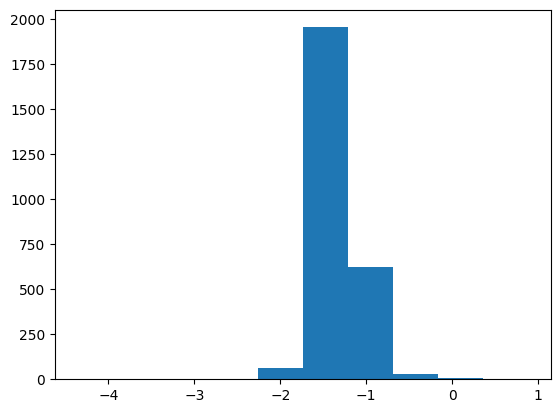

In [46]:
plt.hist(np.array([np.log10(sn.ia_fit['x0_err']) - np.log10(sn.ia_fit['x0']) for sn in all_sne]))

In [47]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ibc_fit.update({'log_mej': np.log10(sn.ibc_fit['mej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'log_x1': np.log10(sn.ia_fit['x1'] + 5)})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})
    sn.ibc_fit.update({'log_ibc_chisq': np.log10(sn.ibc_fit['chisq'])})
    sn.ia_fit.update({'log_ia_chisq': np.log10(sn.ia_fit['chisq'])})
    sn.ia_fit.update({'log_x0_err_ratio': np.log10(sn.ia_fit['x0_err']) - np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'x1_err_ratio': sn.ia_fit['x1_err']/sn.ia_fit['x1']})
    sn.ia_fit.update({'c_err_ratio': sn.ia_fit['c_err']/sn.ia_fit['c']})
    sn.ibc_fit.update({'mej_err_ratio': sn.ibc_fit['mej_err']/sn.ibc_fit['mej']})
    sn.ibc_fit.update({'fni_err_ratio': sn.ibc_fit['fni_err']/sn.ibc_fit['fni']})
    sn.ibc_fit.update({'log_vej_err_ratio': np.log10(sn.ibc_fit['vej_err']) - np.log10(sn.ibc_fit['vej'])})


for sn in all_phot_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ibc_fit.update({'log_mej': np.log10(sn.ibc_fit['mej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ia_fit.update({'log_x1': np.log10(sn.ia_fit['x1'] + 5)})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})


In [48]:
all_sne[100].true_class

'SN Ia'

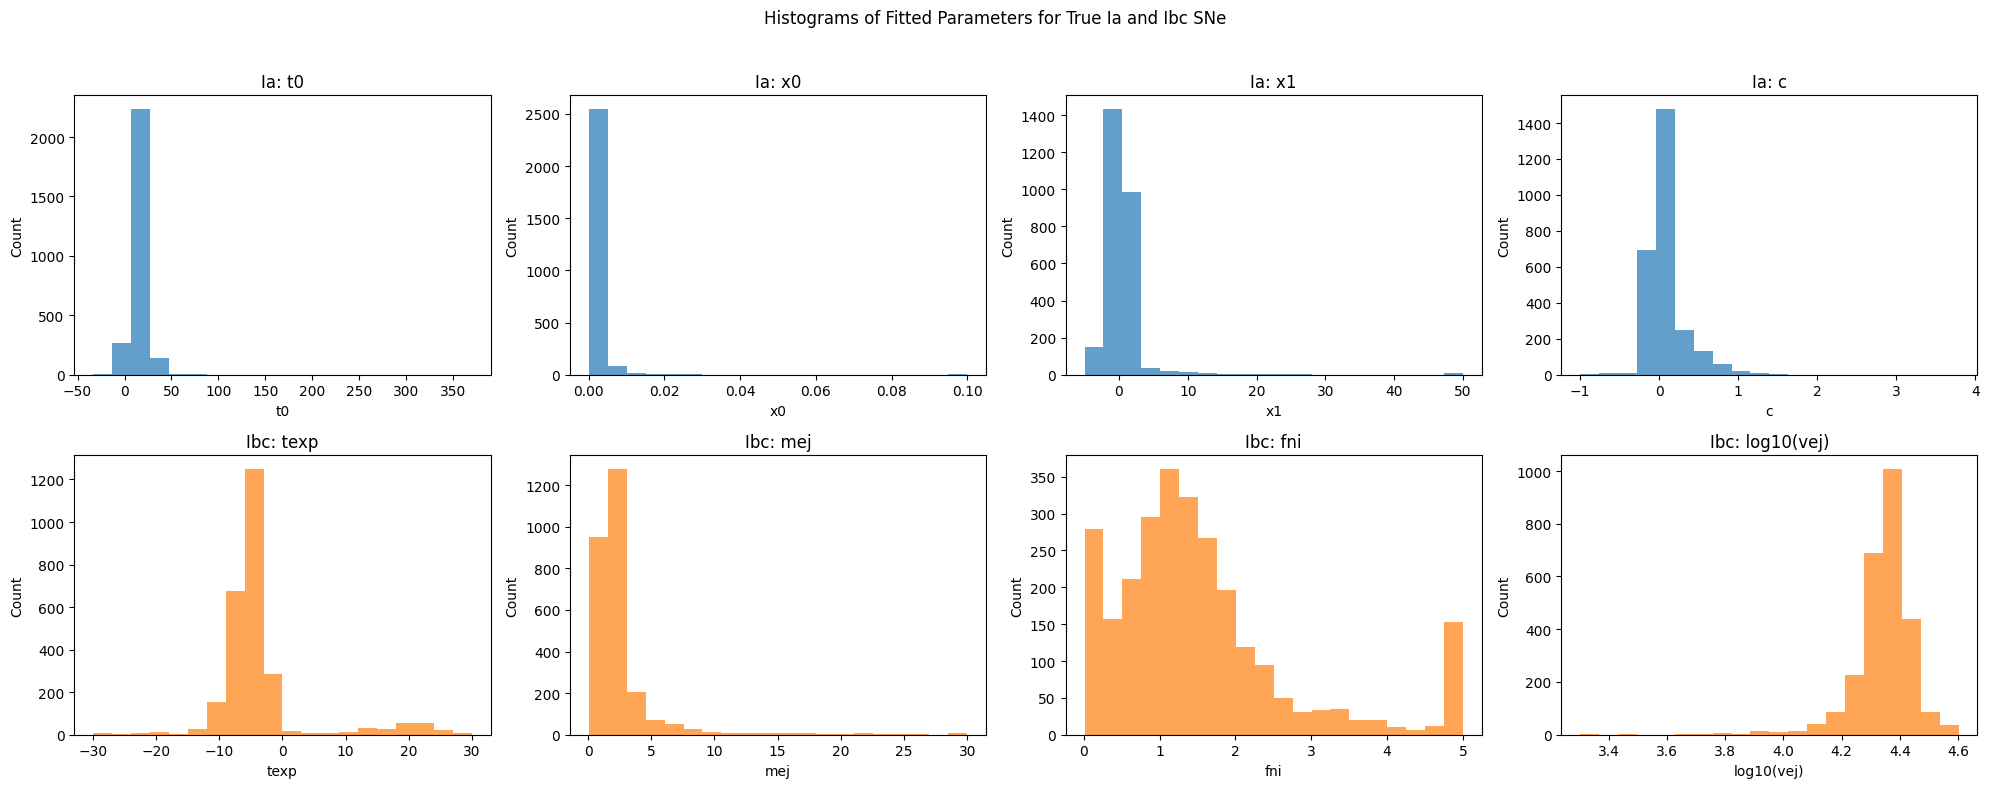

In [49]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

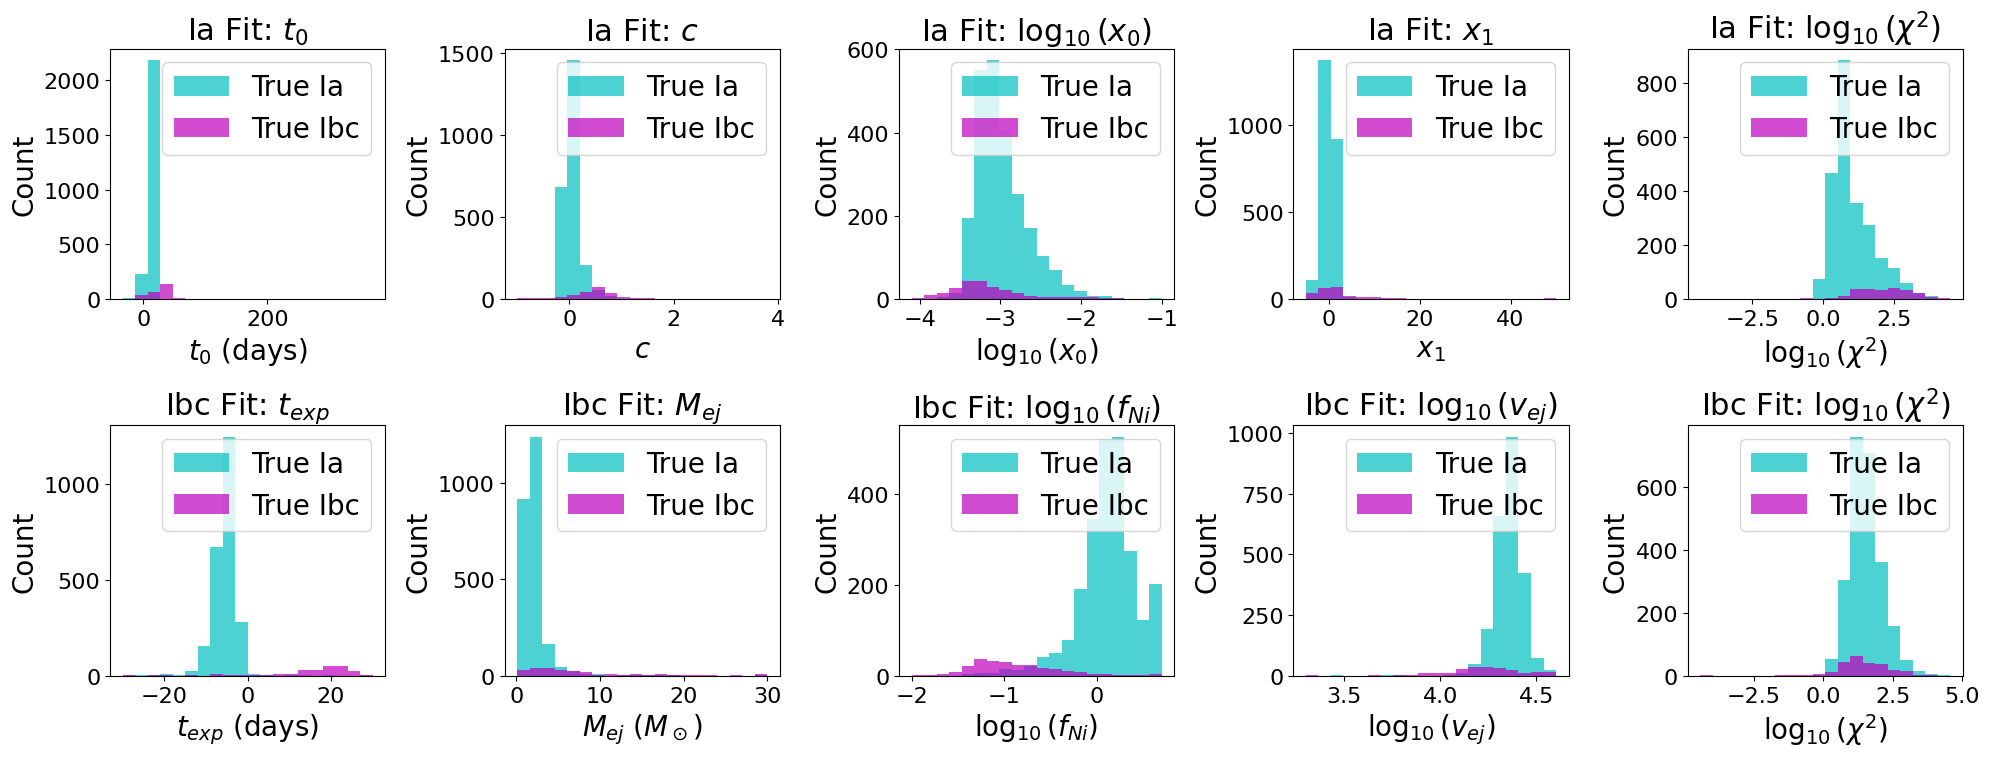

In [50]:
param_labels = {
    't0': r'$t_0$ (days)',
    'log_x0': r'$\log_{10}(x_0)$',
    'log_x1': r'$\log_{10}(x_1)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$ (days)',
    'mej': r'$M_{ej}$ ($M_\odot$)',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'log_mej': r'$\log_{10}(M_{ej})$',
    'log_ia_chisq': r'$\log_{10}(\chi^2)$',
    'log_ibc_chisq': r'$\log_{10}(\chi^2)$',
    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$(x_0)$',
}

param_labels_no_units = {
    't0': r'$t_0$',
    'log_x0': r'$\log_{10}(x_0)$',
    'log_x1': r'$\log_{10}(x_1)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$',
    'mej': r'$M_{ej}$',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'log_mej': r'$\log_{10}(M_{ej})$',
    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'log_ia_chisq': r'$\log_{10}(\chi^2)$',
    'log_ibc_chisq': r'$\log_{10}(\chi^2)$',
    'x0': r'$(x_0)$',
}


labelfontsize = 20
titlefontsize = 22
tickfontsize = 16

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
# for i, param in enumerate(ia_param_names[:4]):
for i, param in enumerate(['t0', 'c', 'log_x0', 'x1', 'log_ia_chisq']):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    if param == 'x0':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia', density=False)
    axes[0, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc', density=False)
    axes[0, i].set_title(f"Ia Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[0, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[0, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[0, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[0, i].legend(fontsize=labelfontsize)

# Plot Ibc fitted parameters
# for i, param in enumerate(ibc_param_names[:4]):
for i, param in enumerate(['texp', 'mej',  'log_fni', 'log_vej', 'log_ibc_chisq']):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej' or param == 'fni':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia', density=False)
    axes[1, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc', density=False)
    axes[1, i].set_title(f"Ibc Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[1, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[1, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[1, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[1, i].legend(fontsize=labelfontsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [51]:
# fig.savefig("figures/fitted_params_histogram.pdf", bbox_inches='tight')

Here we have 8 parameters that we can use to constrain the mixing fraction

In [52]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [53]:
def get_param_samples(param_name, sn_sample = all_sne):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in sn_sample])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in sn_sample])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([2.632e+03, 2.700e+01, 8.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([7.88257576e-05, 1.00709432e-02, 2.00630606e-02, 3.00551780e-02,
        4.00472955e-02, 5.00394129e-02, 6.00315303e-02, 7.00236477e-02,
        8.00157652e-02, 9.00078826e-02, 1.00000000e-01]),
 <BarContainer object of 10 artists>)

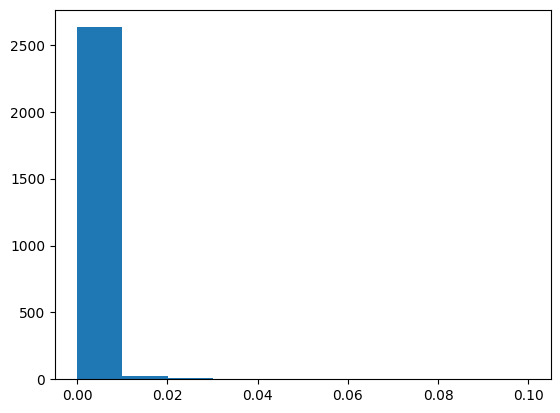

In [54]:
plt.hist(get_param_samples('x0'))

In [55]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(2674, 1)

In [56]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'log_x1', 'log_x0', 'log_fni', 'log_vej', 'x1', 'x0', 'fni', 
                 'log_ia_chisq', 'log_ibc_chisq']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    # samples = get_param_samples(param_name).reshape(-1, 1)
    # gm = GaussianMixture(n_components=2).fit(samples)
    # mus_a[param_name] = gm.means_[0][0]
    # mus_b[param_name] = gm.means_[1][0]
    # sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    # sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    # print(param_name, gm.weights_, sigmas_a[param_name], sigmas_b[param_name])
    mus_a[param_name] = np.median(get_param_samples(param_name)) - np.std(get_param_samples(param_name))
    mus_b[param_name] = np.median(get_param_samples(param_name)) + np.std(get_param_samples(param_name))
    sigmas_a[param_name] = np.std(get_param_samples(param_name))
    sigmas_b[param_name] = np.std(get_param_samples(param_name))

In [57]:
def get_hierarchical_weights(weight_param):
    arr = np.array([sn.ia_fit[weight_param] if weight_param in sn.ia_fit else sn.ibc_fit[weight_param] for sn in all_sne])
    # order = np.argsort(arr)
    # # Create an array of weights that decrease linearly from 1 to 0 based on the sorted order
    # # We want the objects with the lowest percent error to have the highest weights
    # weights = np.zeros_like(arr, dtype=float)
    # n = len(arr)
    # for rank, idx in enumerate(order):
    #     weights[idx] = 1.0 - rank / (n - 1)
    # return weights
    # Normalize to a max of 1
    weights = 1 - (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    return 1 - weights  # Invert so that lower values have higher weights
                                         


In [58]:
np.argsort([sn.ia_fit['x1_err_ratio'] for sn in all_sne]), len(all_sne)

(array([1369, 1604,  904, ...,  963, 1384,  798]), 2674)

In [59]:
get_hierarchical_weights('x1_err_ratio')

array([0.33118751, 0.33140154, 0.33135445, ..., 0.33090748, 0.33141177,
       0.33093323])

In [60]:
num_epochs = 200
lls = np.zeros(num_epochs)

alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.1  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'log_mej': [], 'log_fni': [], 'fni': [],
            'log_vej': [], 't0': [], 'x0': [], 'log_x0': [], 'x1':[], 'log_x1': [], 'c': [],
            'log_ia_chisq': [], 'log_ibc_chisq': []}
gammas_b = {'texp': [], 'mej': [], 'log_mej': [], 'log_fni': [], 'fni': [],'log_vej': [], 't0': [], 'x0': [], 'log_x0': [], 'x1':[], 'log_x1': [], 'c': [],
            'log_ia_chisq': [], 'log_ibc_chisq': []}

# params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
params_to_use = ['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
# params_to_use = ['c', 'mej']

# params_to_use = list(mus_a.keys())  # Use all parameters for fitting

sigma_clip_masks = {}
for param_name in params_to_use:
    param_samples = get_param_samples(param_name)
    clipped = sigma_clip(param_samples, sigma=10, maxiters=3)
    sigma_clip_masks[param_name] = ~clipped.mask
    # sigma_clip_masks[param_name] = np.ones_like(sigma_clip_masks[param_name])
    print(f"{param_name}: {sum(clipped.mask)} samples clipped")


len(all_sne), len(true_ia_sne)/len(all_sne)

weights = {}
weights['c'] = get_hierarchical_weights('c_err_ratio')
weights['mej'] = get_hierarchical_weights('mej_err_ratio')
weights['x1'] = get_hierarchical_weights('x1_err_ratio')
weights['log_x0'] = get_hierarchical_weights('log_x0_err_ratio')
weights['log_fni'] = get_hierarchical_weights('fni_err_ratio')
weights['log_vej'] = get_hierarchical_weights('log_vej_err_ratio')
weights['log_ia_chisq'] = np.ones(len(all_sne))
weights['log_ibc_chisq'] = np.ones(len(all_sne))


# for i, sn in enumerate(true_ia_sne):
#     weights[i] = len(true_ia_sne) / (len(all_sne) - len(true_ia_sne))
#     weights[i] = 1.0

# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)
        mask = sigma_clip_masks[param_name]
        param_samples = param_samples[mask]
        these_weights = weights[param_name][mask]

        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        # mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        # mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        # sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        # sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))


        mus_a[param_name] = np.sum(these_weights * gammas_a[param_name] * param_samples) / np.sum(these_weights * gammas_a[param_name])
        mus_b[param_name] = np.sum(these_weights * gammas_b[param_name] * param_samples) / np.sum(these_weights * gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(these_weights * gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(these_weights * gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(these_weights * gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(these_weights * gammas_b[param_name]))

        if sigmas_a[param_name] < 0.001:
            sigmas_a[param_name] = 0.001
        if sigmas_b[param_name] < 0.001:
            sigmas_b[param_name] = 0.001
    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], 
                                     get_param_samples(param_name)[sigma_clip_masks[param_name]], alpha)

print(lls[-1])
for param_name in params_to_use:
    param_samples = get_param_samples(param_name)
    gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
    gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
    gamma_total = (gammas_a[param_name] + gammas_b[param_name])
    gammas_a[param_name] /= gamma_total
    gammas_b[param_name] /= gamma_total
    

c: 1 samples clipped
mej: 0 samples clipped
x1: 20 samples clipped
log_x0: 0 samples clipped
log_fni: 0 samples clipped
log_vej: 0 samples clipped
log_ia_chisq: 0 samples clipped
log_ibc_chisq: 0 samples clipped
Alpha 0.14722528296934084
Alpha 0.1730034734246094
Alpha 0.21646728699480317
Alpha 0.26719789048342757
Alpha 0.3181891718830603
Alpha 0.3655165397015352
Alpha 0.4073612522415411
Alpha 0.44364419234568264
Alpha 0.4750820468829331
Alpha 0.5024728783961748
Alpha 0.5264805364918849
Alpha 0.5476215029453135
Alpha 0.5663005457100346
Alpha 0.5828450264378696
Alpha 0.5975280143976769
Alpha 0.6105820618936909
Alpha 0.6222072669109927
Alpha 0.6325763969979392
Alpha 0.6418386924072285
Alpha 0.650123104779068
Alpha 0.6575412245022162
Alpha 0.6641899202805314
Alpha 0.670153650479628
Alpha 0.6755064198254942
Alpha 0.6803133906517845
Alpha 0.6846321871423732
Alpha 0.6885139454163809
Alpha 0.6920041636293824
Alpha 0.6951433996607452
Alpha 0.6979678542027331
Alpha 0.7005098673029652
Alpha 0.702

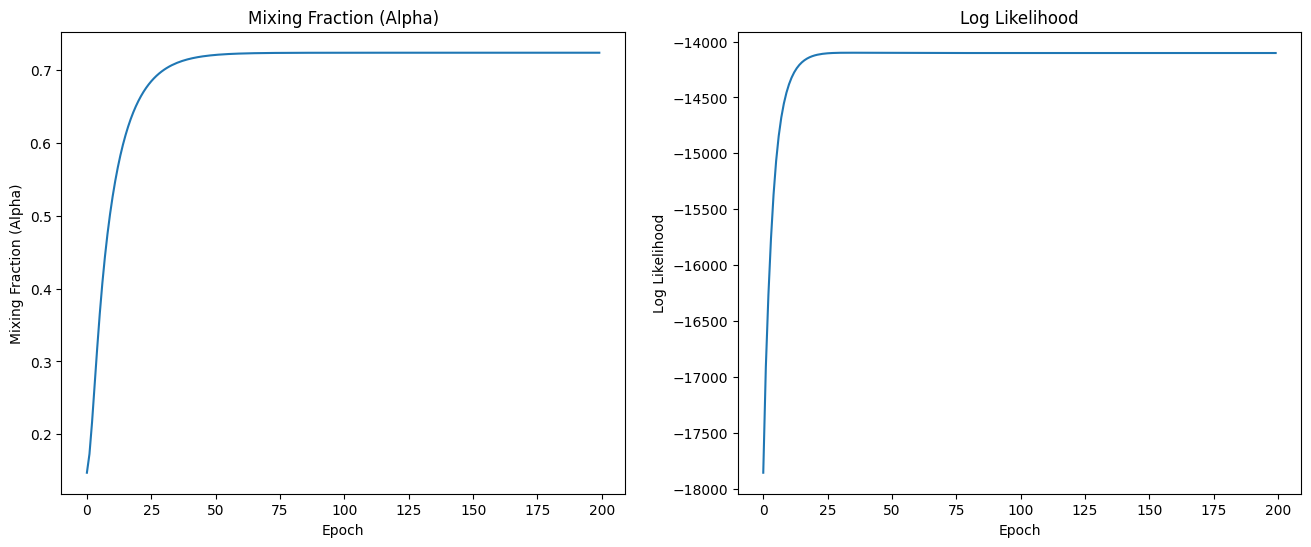

In [61]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [62]:
prob_a = np.ones(len(all_sne))

for i in range(len(all_sne)):
    s = 0
    b = 0
    for param in params_to_use:
        s += gammas_a[param][i]
        b += gammas_b[param][i]
    prob_a[i] = s / (s + b)

(array([  5.,  19.,  39.,  89., 151., 348., 407., 920., 652.,  44.]),
 array([0.241109  , 0.31051258, 0.37991617, 0.44931976, 0.51872335,
        0.58812694, 0.65753052, 0.72693411, 0.7963377 , 0.86574129,
        0.93514487]),
 <BarContainer object of 10 artists>)

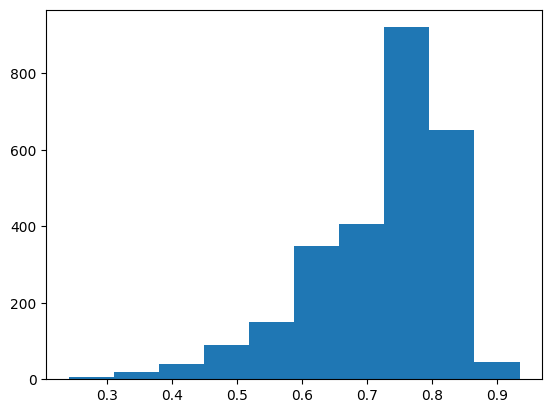

In [63]:
plt.hist(prob_a)

In [64]:
classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in all_sne]

# true_classes

2386 85 36 167
0.9240837696335078


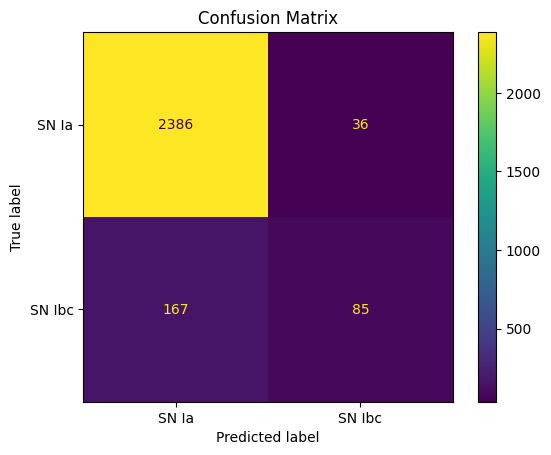

Ia accuracy: 0.9851362510322048
Ibc accuracy: 0.3373015873015873


In [65]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("Ia accuracy:", (num_correct_ia) / (num_correct_ia + num_wrong_true_ia))
print("Ibc accuracy:", (num_correct_ibc) / (num_correct_ibc + num_wrong_true_ibc))

In [66]:
classifications_rough = np.ones(len(all_sne))
for i in range(len(all_sne)):
    probs = np.array([gammas_a[param][i] for param in params_to_use])
    num_a = sum(probs >= 0.5)
    if num_a >=4:
        classifications_rough[i] = 0
classifications_rough = ['SN Ia' if i == 0 else 'SN Ibc' for i in classifications_rough]


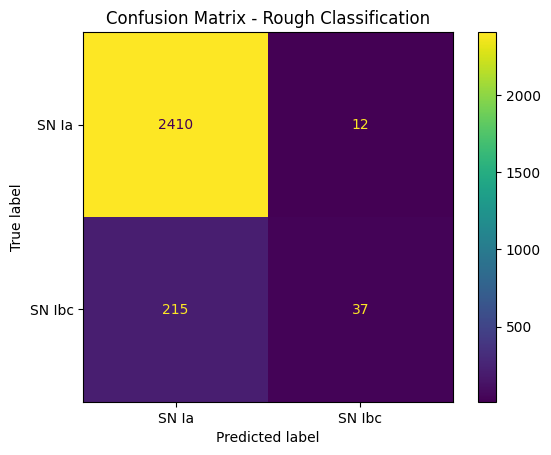

2410 37 12 215
0.9151084517576664


In [67]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications_rough):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

cm = confusion_matrix(true_classes, classifications_rough, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix - Rough Classification")
plt.show()

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

In [68]:
params_to_use

['c',
 'mej',
 'x1',
 'log_x0',
 'log_fni',
 'log_vej',
 'log_ia_chisq',
 'log_ibc_chisq']

{'c': 0.7275519237575901, 'mej': 0.7060115398519047, 'x1': 1.2963865681769815, 'log_x0': 1.1494154675751602, 'log_fni': 0.3518306983341661, 'log_vej': 0.1675854299922723, 'log_ia_chisq': 0.5632024056277032, 'log_ibc_chisq': 0.37909053128284786}
2342 144 80 108
0.9296933433059088


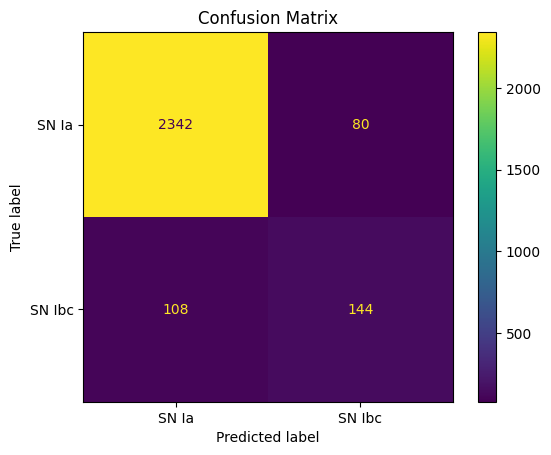

Ia accuracy: 0.9669694467382328
Ibc accuracy: 0.5714285714285714


In [69]:
from scipy.stats import entropy
from scipy.special import kl_div

param_weights = {}
for param in params_to_use:
    # ia_vals = [sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
    #            for sn in true_ia_sne]
    # ibc_vals = [sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
    #             for sn in true_ibc_sne]
    
    # # Use histogram-based KL divergence as weight
    # bins = np.histogram_bin_edges(ia_vals + ibc_vals, bins=30)
    # p_ia, _ = np.histogram(ia_vals, bins=bins, density=True)
    # p_ibc, _ = np.histogram(ibc_vals, bins=bins, density=True)
    # p_ia = p_ia + 1e-100  # avoid zeros
    # p_ibc = p_ibc + 1e-100
    # param_weights[param] = entropy(p_ia, p_ibc)
    param_weights[param] = 1 / entropy(gammas_a[param], gammas_b[param])
    # param_weights[param] = 1 / kl_div(gammas_a[param], gammas_b[param]).sum()
    # print(param_weights[param], param_weights[param].sum())


# Then in classification:
weighted_probs = np.zeros(len(all_sne))
for i in range(len(all_sne)):
    weighted_probs[i] = sum(param_weights[p] * gammas_a[p][i] for p in params_to_use) / \
                sum(param_weights[p] * (gammas_a[p][i] + gammas_b[p][i]) for p in params_to_use)

print(param_weights)

# Classify SNe based on weighted probabilities
weighted_classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in weighted_probs]
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, weighted_classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, weighted_classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

print("Ia accuracy:", (num_correct_ia) / (num_correct_ia + num_wrong_true_ia))
print("Ibc accuracy:", (num_correct_ibc) / (num_correct_ibc + num_wrong_true_ibc))

In [70]:
# for n in sigmas_b.keys():
#     if sigmas_b[n] <= 0.01:
#         sigmas_b[n] = 0.01

# for n in sigmas_a.keys():
#     if sigmas_a[n] <= 0.01:
#         sigmas_a[n] = 0.01

In [71]:
# sigmas_a['x0'] = 1e-5
# sigmas_b['x0'] = 1e-6

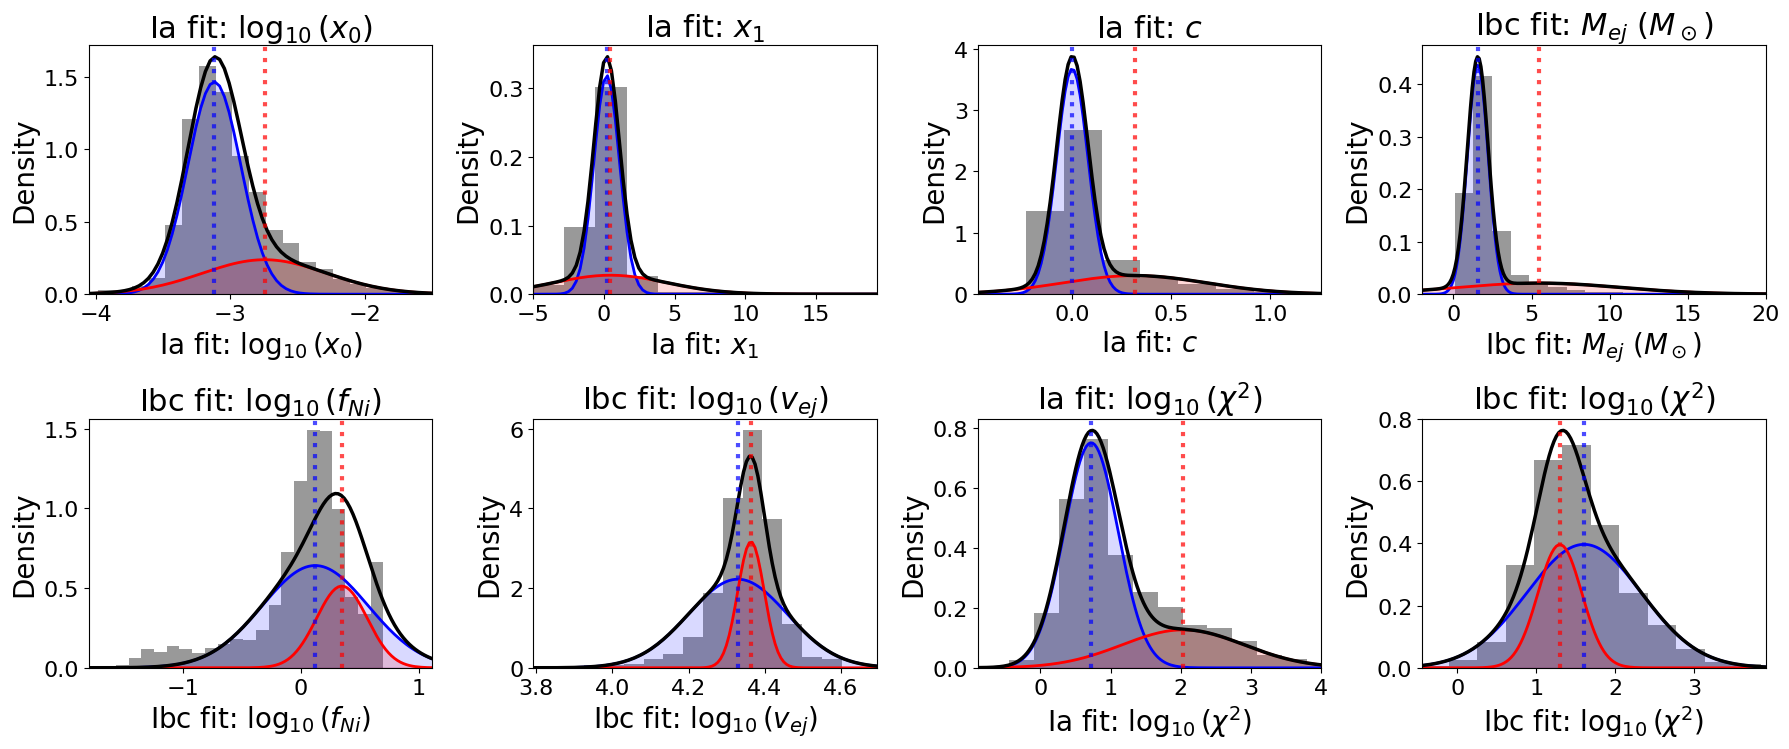


Fitted Gaussian Mixture Parameters:
----------------------------------------------------------------------
Parameter           μ_A        σ_A        μ_B        σ_B
----------------------------------------------------------------------
log_x0          -3.1197     0.1967    -2.7474     0.4625
x1               0.1930     0.9053     0.4521     3.9896
c                0.0008     0.0786     0.3151     0.3644
mej              1.5596     0.6605     5.4719     5.2234
log_fni          0.1213     0.4499     0.3477     0.2147
log_vej          4.3294     0.1298     4.3637     0.0348
log_ia_chisq     0.7226     0.3841     2.0324     0.8686
log_ibc_chisq     1.6074     0.7275     1.3011     0.2780


In [72]:
# Define x ranges for plotting
x_ranges = {
    't0': np.linspace(-50, 100, 200),
    'log_x0': np.linspace(-6, 1, 200),
    'x1': np.linspace(-5, 50, 200),
    'c': np.linspace(-1, 2, 200),
    'texp': np.linspace(-20, 50, 200),
    'mej': np.linspace(-2, 20, 200),
    'log_fni': np.linspace(-3, 2, 200),
    'fni': np.linspace(0, 3, 200),
    'log_vej': np.linspace(3.5, 5, 200),
    'log_x1': np.linspace(-2, 2, 200),
    'log_mej': np.linspace(-1, 2, 200),
    'log_ia_chisq': np.linspace(-2, 4, 200),
    'log_ibc_chisq': np.linspace(-2, 4, 200)
}

# Parameter display names
param_labels = {
    't0': r'Ia fit: $t_0$ (days)',
    'log_x0': r'Ia fit: $\log_{10}(x_0)$',
    'log_x1': r'Ia fit: $\log_{10}(x_1 + 5)$',
    'x1': r'Ia fit: $x_1$',
    'c': r'Ia fit: $c$',
    'texp': r'Ibc fit: $t_{exp}$ (days)',
    'mej': r'Ibc fit: $M_{ej}$ ($M_\odot$)',
    'log_fni': r'Ibc fit: $\log_{10}(f_{Ni})$',
    'fni': r'Ibc fit: $f_{Ni}$',
    'log_vej': r'Ibc fit: $\log_{10}(v_{ej})$',
    'log_mej': r'Ibc fit: $\log_{10}(M_{ej})$',
    'log_ia_chisq': r'Ia fit: $\log_{10}(\chi^2)$',
    'log_ibc_chisq': r'Ibc fit: $\log_{10}(\chi^2)$',
}

# Create figure with better styling
# fig.suptitle(f"Gaussian Mixture Model Fits (Mixing Fraction α = {alpha:.3f})", fontsize=14, fontweight='bold')

# params_plot = ['t0', 'log_x0', 'x1', 'c', 'texp', 'mej', 'log_fni', 'log_vej']
params_plot = ['log_x0', 'x1', 'c', 'mej', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
# params_plot = ['c', 'mej']

fig, axes = plt.subplots(2, len(params_plot) // 2, figsize=(18, 8))


for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = get_param_samples(param)
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram with better styling
    n, bins, patches = ax.hist(samples, bins=25, density=True,  alpha=0.4,
                                color='black', linewidth=0.5,
                                label='Data')
    
    # Compute mixture components
    y_a = alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components with better styling
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves for visibility
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits based on data
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=labelfontsize)
    ax.set_ylabel('Density', fontsize=labelfontsize)
    ax.set_title(param_labels[param], fontsize=titlefontsize)
    # ax.legend(fontsize=labelfontsize, loc='upper right')
    ax.tick_params(axis='both', labelsize=tickfontsize)

    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=3)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("figures/gmm_results.pdf", bbox_inches='tight')

# Print summary statistics
print("\nFitted Gaussian Mixture Parameters:")
print("-" * 70)
print(f"{'Parameter':<12} {'μ_A':>10} {'σ_A':>10} {'μ_B':>10} {'σ_B':>10}")
print("-" * 70)
for param in params_plot:
        print(f"{param:<12} {mus_a[param]:>10.4f} {sigmas_a[param]:>10.4f} {mus_b[param]:>10.4f} {sigmas_b[param]:>10.4f}")

In [73]:
def fit_gmm(sn_sample = all_sne, initial_alpha = 0.5, verbose = False):

    mus_a = {}
    mus_b = {}
    sigmas_a = {}
    sigmas_b = {}

    params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej',
                     'log_ia_chisq', 'log_ibc_chisq']

    print(len(sn_sample))

    # Initialize parameters
    for param_name in params_to_use:
        mus_a[param_name] = np.median(get_param_samples(param_name, sn_sample))
        mus_b[param_name] = np.median(get_param_samples(param_name, sn_sample))
        sigmas_a[param_name] = np.std(get_param_samples(param_name, sn_sample))
        sigmas_b[param_name] = np.std(get_param_samples(param_name, sn_sample))

    num_epochs = 200
    lls = np.zeros(num_epochs)

    alphas = np.zeros(num_epochs)
    alpha = initial_alpha
    gammas_a = {k: [] for k in ['texp', 'mej', 'log_mej', 'log_fni', 'fni',
                'log_vej', 't0', 'log_x0', 'log_x1', 'c',
                'log_ia_chisq', 'log_ibc_chisq']}
    gammas_b = {k: [] for k in gammas_a}

    # Pre-compute sigma clip masks per parameter
    sigma_clip_masks = {}
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name, sn_sample)
        clipped = sigma_clip(param_samples, sigma=10, maxiters=3)
        sigma_clip_masks[param_name] = ~clipped.mask
        # sigma_clip_masks[param_name] = np.ones_like(sigma_clip_masks[param_name])

    # Compute per-parameter hierarchical weights
    weight_map = {
        'c': 'c_err_ratio', 'mej': 'mej_err_ratio', 'x1': 'x1_err_ratio',
        'log_x0': 'log_x0_err_ratio', 'log_fni': 'fni_err_ratio',
        'log_vej': 'log_vej_err_ratio',
    }
    weights = {}
    for param_name in params_to_use:
        if param_name in weight_map:
            arr = np.array([sn.ia_fit[weight_map[param_name]] if weight_map[param_name] in sn.ia_fit else sn.ibc_fit[weight_map[param_name]] for sn in sn_sample])
            w = 1 - (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
            weights[param_name] = 1 - w
        else:
            weights[param_name] = np.ones(len(sn_sample))

    # EM iterations
    for epoch in range(num_epochs):
        for param_name in params_to_use:
            param_samples = get_param_samples(param_name, sn_sample)
            mask = sigma_clip_masks[param_name]
            param_samples = param_samples[mask]
            these_weights = weights[param_name][mask]

            # E-step
            gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
            gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])

            gamma_total = (gammas_a[param_name] + gammas_b[param_name])
            gammas_a[param_name] /= gamma_total
            gammas_b[param_name] /= gamma_total

            # M-step with weights
            mus_a[param_name] = np.sum(these_weights * gammas_a[param_name] * param_samples) / np.sum(these_weights * gammas_a[param_name])
            mus_b[param_name] = np.sum(these_weights * gammas_b[param_name] * param_samples) / np.sum(these_weights * gammas_b[param_name])
            sigmas_a[param_name] = np.sqrt(np.sum(these_weights * gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(these_weights * gammas_a[param_name]))
            sigmas_b[param_name] = np.sqrt(np.sum(these_weights * gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(these_weights * gammas_b[param_name]))

            if sigmas_a[param_name] < 0.001:
                sigmas_a[param_name] = 0.001
            if sigmas_b[param_name] < 0.001:
                sigmas_b[param_name] = 0.001

        alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
        alphas[epoch] = alpha
        if verbose:
            print("Alpha", alpha)

        # Log likelihood on clipped samples
        for param_name in params_to_use:
            mask = sigma_clip_masks[param_name]
            lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]],
                                         get_param_samples(param_name, sn_sample)[mask], alpha)

    fit_params = mus_a, mus_b, sigmas_a, sigmas_b

    # Recompute gammas on ALL samples for classification
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name, sn_sample)
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total

    return alpha, lls[-1], gammas_a, gammas_b, fit_params

In [74]:
def classify_sample(sn_sample, gammas_a, gammas_b):

    prob_a = np.ones(len(sn_sample))

    print(params_to_use)
    for i in range(len(sn_sample)):
        s = 0
        b = 0
        for param in params_to_use:
            s += gammas_a[param][i]
            b += gammas_b[param][i]
        prob_a[i] = s / (s + b)

    classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
    true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in sn_sample]

    # Calculate accuracy
    num_correct_ia = 0
    num_correct_ibc = 0
    num_wrong_true_ia = 0
    num_wrong_true_ibc = 0

    for a,b in zip(true_classes, classifications):
        if a == 'SN Ia':
            if b == 'SN Ia':
                num_correct_ia += 1
            else:
                num_wrong_true_ia += 1
        else:
            if b == 'SN Ibc':
                num_correct_ibc += 1
            else:
                num_wrong_true_ibc += 1

    accuracy = (num_correct_ia + num_correct_ibc) / len(sn_sample)
    ia_accuracy = num_correct_ia / (num_correct_ia + num_wrong_true_ia)
    ibc_accuracy = num_correct_ibc / (num_correct_ibc + num_wrong_true_ibc)
    if accuracy < 0.5:
        accuracy = 1 - accuracy
        ia_accuracy = 1 - ia_accuracy
        ibc_accuracy = 1 - ibc_accuracy
    return accuracy, ia_accuracy, ibc_accuracy

In [75]:
def classify_sample_entropy(sn_sample, gammas_a, gammas_b):
    param_weights = {}
    for param in params_to_use:
        param_weights[param] = 1 / entropy(gammas_a[param], gammas_b[param])

    # Then in classification:
    weighted_probs = np.zeros(len(sn_sample))
    for i in range(len(sn_sample)):
        weighted_probs[i] = sum(param_weights[p] * gammas_a[p][i] for p in params_to_use) / \
                    sum(param_weights[p] * (gammas_a[p][i] + gammas_b[p][i]) for p in params_to_use)

    print(param_weights)

    # Classify SNe based on weighted probabilities
    weighted_classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in weighted_probs]
    true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in sn_sample]

    num_correct_ia = 0
    num_correct_ibc = 0
    num_wrong_true_ia = 0
    num_wrong_true_ibc = 0


    for a,b in zip(true_classes, weighted_classifications):
        if a == 'SN Ia':
            if b == 'SN Ia':
                num_correct_ia += 1
            else:
                num_wrong_true_ia += 1
        else:
            if b == 'SN Ibc':
                num_correct_ibc += 1
            else:
                num_wrong_true_ibc += 1

    accuracy = (num_correct_ia + num_correct_ibc) / len(sn_sample)
    ia_accuracy = num_correct_ia / (num_correct_ia + num_wrong_true_ia)
    ibc_accuracy = num_correct_ibc / (num_correct_ibc + num_wrong_true_ibc)
    # if accuracy < 0.5:
    #     accuracy = 1 - accuracy
    #     ia_accuracy = 1 - ia_accuracy
    #     ibc_accuracy = 1 - ibc_accuracy
    
    return accuracy, ia_accuracy, ibc_accuracy

In [76]:
# fit_gmm(sn_sample = all_sne, initial_alpha = 0.6)
# for i in range(1,10):
#     print(f"Initial alpha: {i/10}")
#     final_alpha, final_ll, final_gammas_a, final_gammas_b, _ = fit_gmm(sn_sample = all_sne, initial_alpha = i/10)
#     print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
#     print("Classification accuracy:", classify_sample(all_sne, final_gammas_a, final_gammas_b)[0])


In [77]:
len(true_ia_sne), len(true_ibc_sne)

(2422, 252)

2673
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
2423
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
2173
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1923
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1673
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1423
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1173
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
923
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
673
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
423
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']


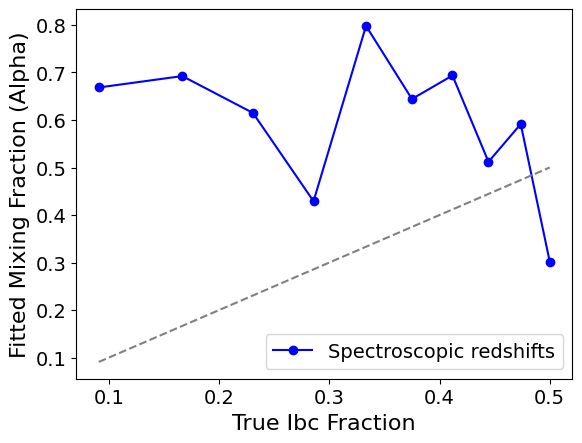

In [90]:
ratios = [(25 * (i + 1))/ (25 * (i + 1) + 250) for i in range(10)]


def mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios, fitting_method=fit_gmm):
    final_alphas = []
    accuracies = np.zeros((3, len(ratios)))
    for i in range(10):
        # print(25*(i + 1))
        # split_population = np.concatenate((true_ia_sne, true_ibc_sne[1:25*(i + 1)]))
        split_population = np.concatenate((true_ia_sne[1:len(true_ia_sne)-250*i], true_ibc_sne))

        # print(f"Population split: {(25 * (i + 1))/ (25 * (i + 1) + 250)}")
        # final_alpha, final_ll = fit_gmm(sn_sample = split_population, initial_alpha = (25 * (i + 1))/ (25 * (i + 1) + 250))
        final_alpha, _, final_gammas_a, final_gammas_b, _ = fitting_method(sn_sample = split_population, 
                                                                           initial_alpha = 0.1)
        # print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
        final_alphas.append(final_alpha)
        accuracies[:, i] = classify_sample(split_population, final_gammas_a, final_gammas_b)
    return final_alphas, accuracies

final_alphas_spec, accuracies_spec = mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios)
# final_alphas_phot, accuracies_phot = mixing_fraction_analysis(true_ia_phot_sne, true_ibc_phot_sne, ratios)

plt.plot(ratios, 1 - np.array(final_alphas_spec), marker='o', color='blue', label='Spectroscopic redshifts')
# plt.plot(ratios, 1 - np.array(final_alphas_phot), marker='o', color='red', label='Photometric redshifts')
plt.plot(ratios, ratios, linestyle='--', color='gray')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Fitted Mixing Fraction (Alpha)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()

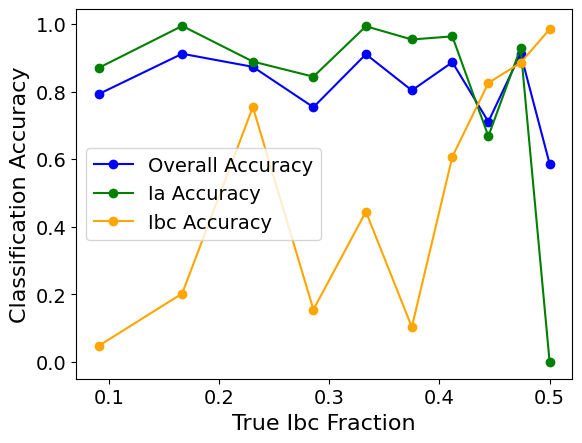

In [92]:
plt.plot(ratios, accuracies_spec[0,:], marker='o', color='blue', label='Overall Accuracy')
plt.plot(ratios, accuracies_spec[1,:], marker='o', color='green', label='Ia Accuracy')
plt.plot(ratios, accuracies_spec[2,:], marker='o', color='orange', label='Ibc Accuracy')

# plt.plot(ratios, accuracies_phot[0,:], marker='o', color='red', label='Photometric redshifts')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/accuracy_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()

In [80]:
known_sne = np.random.choice(all_sne, size=int(0.1 * len(all_sne)), replace=False)

def fit_gmm_fix_some_classes(sn_sample = all_sne, initial_alpha = 0.1, verbose = False):

    mus_a = {}
    mus_b = {}
    sigmas_a = {}
    sigmas_b = {}

    params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej',
                     'log_ia_chisq', 'log_ibc_chisq']

    print(len(sn_sample))
    known_sne = np.random.choice(sn_sample, size=int(0.1 * len(sn_sample)), replace=False)

    # Initialize parameters
    for param_name in params_to_use:
        mus_a[param_name] = np.median(get_param_samples(param_name, sn_sample))
        mus_b[param_name] = np.median(get_param_samples(param_name, sn_sample))
        sigmas_a[param_name] = np.std(get_param_samples(param_name, sn_sample))
        sigmas_b[param_name] = np.std(get_param_samples(param_name, sn_sample))

    num_epochs = 200
    lls = np.zeros(num_epochs)

    alphas = np.zeros(num_epochs)
    alpha = initial_alpha
    gammas_a = {k: [] for k in ['texp', 'mej', 'log_mej', 'log_fni', 'fni',
                'log_vej', 't0', 'log_x0', 'log_x1', 'c',
                'log_ia_chisq', 'log_ibc_chisq']}
    gammas_b = {k: [] for k in gammas_a}

    # Pre-compute sigma clip masks per parameter
    sigma_clip_masks = {}
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name, sn_sample)
        clipped = sigma_clip(param_samples, sigma=10, maxiters=3)
        sigma_clip_masks[param_name] = ~clipped.mask
        # sigma_clip_masks[param_name] = np.ones_like(sigma_clip_masks[param_name])

    # Compute per-parameter hierarchical weights
    weight_map = {
        'c': 'c_err_ratio', 'mej': 'mej_err_ratio', 'x1': 'x1_err_ratio',
        'log_x0': 'log_x0_err_ratio', 'log_fni': 'fni_err_ratio',
        'log_vej': 'log_vej_err_ratio',
    }
    weights = {}
    for param_name in params_to_use:
        if param_name in weight_map:
            arr = np.array([sn.ia_fit[weight_map[param_name]] if weight_map[param_name] in sn.ia_fit else sn.ibc_fit[weight_map[param_name]] for sn in sn_sample])
            w = 1 - (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
            weights[param_name] = 1 - w
        else:
            weights[param_name] = np.ones(len(sn_sample))

    # Build index set of known SNe for fast lookup
    known_set = set(id(sn) for sn in known_sne)

    # EM iterations
    for epoch in range(num_epochs):
        for param_name in params_to_use:
            param_samples = get_param_samples(param_name, sn_sample)
            mask = sigma_clip_masks[param_name]
            param_samples = param_samples[mask]
            these_weights = weights[param_name][mask]

            # E-step
            gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
            gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])

            gamma_total = (gammas_a[param_name] + gammas_b[param_name])
            gammas_a[param_name] /= gamma_total
            gammas_b[param_name] /= gamma_total

            # Fix gammas for known SNe (group A = SN Ia, group B = SN Ibc)
            # Use mask-aware indexing: only iterate over non-clipped samples
            mask_indices = np.where(mask)[0]
            for j, orig_idx in enumerate(mask_indices):
                sn = sn_sample[orig_idx]
                if id(sn) in known_set:
                    if sn.true_class == 'SN Ia':
                        gammas_a[param_name][j] = max(gammas_a[param_name][j], 0.51)
                        gammas_b[param_name][j] = 1 - gammas_a[param_name][j]
                    else:
                        gammas_b[param_name][j] = max(gammas_b[param_name][j], 0.51)
                        gammas_a[param_name][j] = 1 - gammas_b[param_name][j]

            # M-step with weights
            mus_a[param_name] = np.sum(these_weights * gammas_a[param_name] * param_samples) / np.sum(these_weights * gammas_a[param_name])
            mus_b[param_name] = np.sum(these_weights * gammas_b[param_name] * param_samples) / np.sum(these_weights * gammas_b[param_name])
            sigmas_a[param_name] = np.sqrt(np.sum(these_weights * gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(these_weights * gammas_a[param_name]))
            sigmas_b[param_name] = np.sqrt(np.sum(these_weights * gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(these_weights * gammas_b[param_name]))

            if sigmas_a[param_name] < 0.001:
                sigmas_a[param_name] = 0.001
            if sigmas_b[param_name] < 0.001:
                sigmas_b[param_name] = 0.001

        alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
        alphas[epoch] = alpha
        if verbose:
            print("Alpha", alpha)

        # Log likelihood on clipped samples
        for param_name in params_to_use:
            mask = sigma_clip_masks[param_name]
            lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]],
                                         get_param_samples(param_name, sn_sample)[mask], alpha)

    fit_params = mus_a, mus_b, sigmas_a, sigmas_b

    # Recompute gammas on ALL samples for classification
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name, sn_sample)
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total

    return alpha, lls[-1], gammas_a, gammas_b, fit_params

In [81]:
fixed_alpha, _, fixed_gammas_a, fixed_gammas_b, fit_params = fit_gmm_fix_some_classes(all_sne, verbose = False)
print("Alpha:", fixed_alpha)
classify_sample(all_sne, fixed_gammas_a, fixed_gammas_b)

2674
Alpha: 0.8211746149410496
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']


(0.9551234106207929, 0.9826589595375722, 0.6904761904761905)

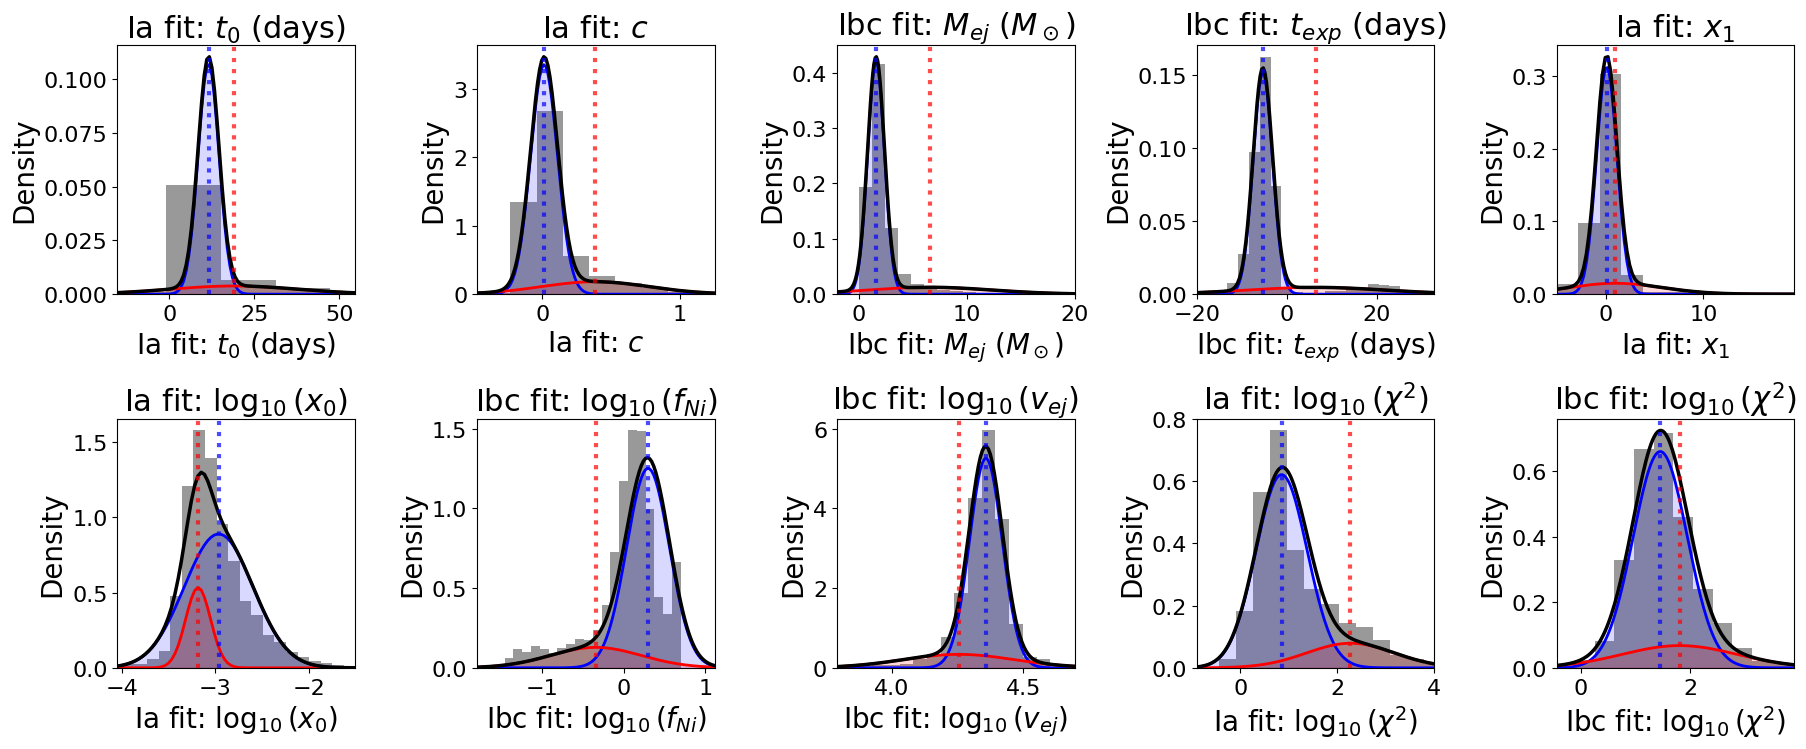

In [82]:
# Plot GMM fits
params_plot = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej',
                     'log_ia_chisq', 'log_ibc_chisq']

fig, axes = plt.subplots(2, len(params_plot)//2, figsize=(18, 8))

mus_a, mus_b, sigmas_a, sigmas_b = fit_params

for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = np.array([sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
                        for sn in all_sne])
    known_samples = np.array([sn.ia_fit[param] if param in ia_param_names else sn.ibc_fit[param] 
                             for sn in all_sne if sn in known_sne])
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram
    n, bins, patches = ax.hist(samples, bins=25, density=True, alpha=0.4,
                                color='black', linewidth=0.5, label='Data')
    
    # Overplot known SNe
    # ax.hist(known_samples, bins=bins, weights=0.1*np.ones(len(known_samples)),
    #         color='green', linewidth=1.5, label='Known SNe')
    
    # Compute mixture components
    y_a = fixed_alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - fixed_alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={fixed_alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-fixed_alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=labelfontsize)
    ax.set_ylabel('Density', fontsize=labelfontsize)
    ax.set_title(param_labels[param], fontsize=titlefontsize)
    ax.tick_params(axis='both', labelsize=tickfontsize)
    # ax.legend(fontsize=labelfontsize)
    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=3)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

2673
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
2423
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
2173
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1923
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1673
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1423
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
1173
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
923
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
673
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']
423
['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej', 'log_ia_chisq', 'log_ibc_chisq']


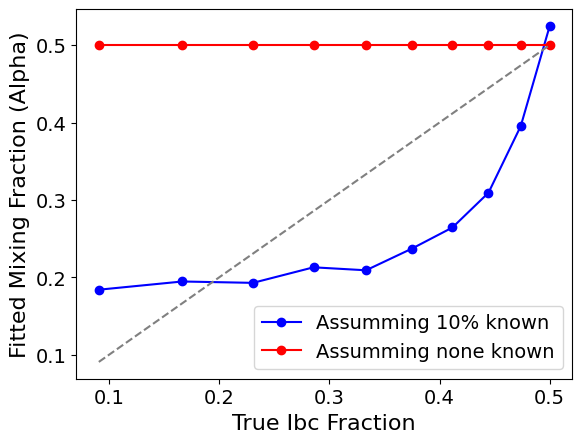

In [83]:
final_alphas_fixed, accuracies_fixed = mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios, fitting_method=fit_gmm_fix_some_classes)

plt.plot(ratios, 1 - np.array(final_alphas_fixed), marker='o', color='blue', label='Assumming 10% known')
plt.plot(ratios, np.array(final_alphas_spec), marker='o', color='red', label='Assumming none known')
plt.plot(ratios, ratios, linestyle='--', color='gray')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Fitted Mixing Fraction (Alpha)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()

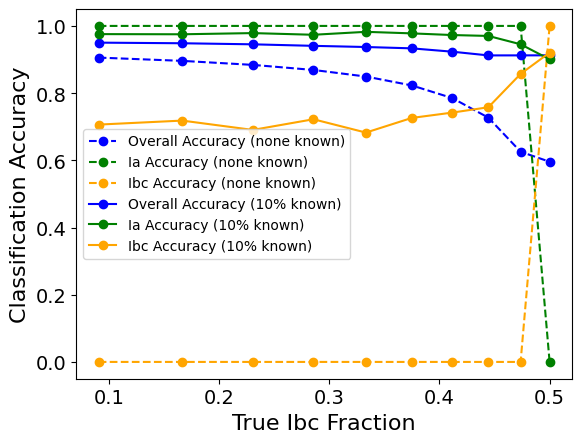

In [84]:
plt.plot(ratios, accuracies_spec[0,:], marker='o', color='blue', linestyle = '--', label='Overall Accuracy (none known)')
plt.plot(ratios, accuracies_spec[1,:], marker='o', color='green', linestyle = '--', label='Ia Accuracy (none known)')
plt.plot(ratios, accuracies_spec[2,:], marker='o', color='orange', linestyle = '--', label='Ibc Accuracy (none known)')

plt.plot(ratios, accuracies_fixed[0,:], marker='o', color='blue', label='Overall Accuracy (10% known)')
plt.plot(ratios, accuracies_fixed[1,:], marker='o', color='green', label='Ia Accuracy (10% known)')
plt.plot(ratios, accuracies_fixed[2,:], marker='o', color='orange', label='Ibc Accuracy (10% known)')


# plt.plot(ratios, accuracies_phot[0,:], marker='o', color='red', label='Photometric redshifts')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
# plt.savefig("figures/accuracy_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()